In [18]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 

import os
import re
import tensorflow
import summa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


## 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
25732,Seven people killed in road accident on Maha h...,At least seven people died on the spot when tw...
80127,World record for the largest cricket lesson se...,As many as 580 school children participated in...
31981,Iran deal had been 'recipe for disaster': Isra...,"Praising US President Donald Trump's ""brave an..."
43657,Was uncomfortable: Teen who was kissed by Katy...,"A 19-year-old teenage boy, who was kissed by s..."
63271,Learnt to work relentlessly from Naseeruddin s...,"Actress Aahana Kumra, who starred in the film ..."
96816,"Fans disrupt Buffon's 1,000th career appearance",Italian goalkeeper Gianluigi Buffon became the...
37438,NZ PM Ardern 2nd world leader to give birth wh...,New Zealand Prime Minister Jacinda Ardern on T...
74778,No one should use force to alter status quo: J...,Japanese ambassador to India Kenji Hiramatsu s...
33169,Top Pope aide to face trial for child sex abuse,"Pope Francis' Chief Financial Adviser, Cardina..."
94540,#OpenStockholm trends on Twitter after Sweden ...,#OpenStockholm was trending on Twitter in the ...


In [7]:
print("데이터 샘플 수 : ", len(data))

데이터 샘플 수 :  98401


## 2. 데이터 전처리하기 (추상적 요약)

### 중복 및 결측치 제거

In [8]:
## 중복 샘플
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

data = data.drop_duplicates(subset = ['text'])
print('전체 샘플수 :', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


In [9]:
## NULL 값 제거 -> NULL 값이 없다..
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화

In [10]:
## 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 전처리 함수 

In [19]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
#         tokens = ' '.join(filter(lambda word: len(word) > 1, sentence.split()))
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
#         tokens = ' '.join(filter(lambda word: len(word) > 1, sentence.split()))
    return tokens

In [20]:
## text 데이터 전처리 
data["filtered_text"] = data["text"].apply(lambda x: preprocess_sentence(x))

In [22]:
## headlines 데이터 전처리 
data["filtered_headlines"] = data["headlines"].apply(lambda x: preprocess_sentence(x, False))

In [23]:
data.head()

,headlines,text,filtered_text,filtered_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


In [24]:
## 혹시 몰라서 저장!
df = data.copy()

In [25]:
## 전처리 후 결측값 확인
data.replace('', np.nan)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 길이에 따라 데이터 제거

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


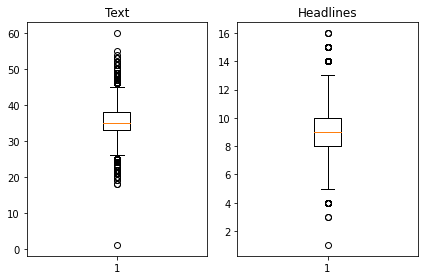

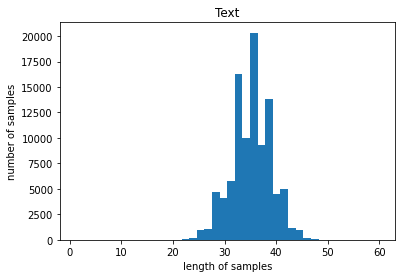

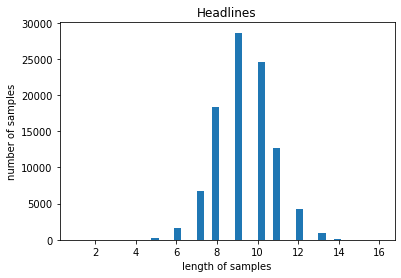

In [27]:
## 길이 분포 출력
text_len = [len(s.split()) for s in data['filtered_text']]
headlines_len = [len(s.split()) for s in data['filtered_headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
text_max_len = 50
headlines_max_len = 12

In [46]:
def below_threshold_len(max_len, nested_list):
    cnt = 0  
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [47]:
below_threshold_len(text_max_len, data['filtered_text'])
below_threshold_len(headlines_max_len,  data['filtered_headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [57]:
filtered_data = data[
    data.apply(lambda x: len(x['filtered_text'].split()) <= text_max_len and len(x['filtered_headlines'].split()) <= headlines_max_len, axis=1)
][["filtered_text", "filtered_headlines"]]

In [60]:
filtered_data.head()

,filtered_text,filtered_headlines
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...


### 시작 토큰과 종료 토큰 추가하기

In [61]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
filtered_data['decoder_input'] = filtered_data['filtered_headlines'].apply(lambda x : 'sostoken '+ x)
filtered_data['decoder_target'] = filtered_data['filtered_headlines'].apply(lambda x : x + ' eostoken')
filtered_data.head()

,filtered_text,filtered_headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [63]:
##  Numpy 타입으로 저장
encoder_input = np.array(filtered_data['filtered_text']) # 인코더의 입력
decoder_input = np.array(filtered_data['decoder_input']) # 디코더의 입력
decoder_target = np.array(filtered_data['decoder_target']) # 디코더의 레이블

### 훈련데이터와 테스트 데이터 분리하기

In [64]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
## 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

## 분리하기
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [65]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [66]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69153
등장 빈도가 6번 이하인 희귀 단어의 수: 47094
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22059
단어 집합에서 희귀 단어의 비율: 68.10116697757147
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.510264027406406


In [67]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [68]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [69]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [70]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29948
등장 빈도가 5번 이하인 희귀 단어의 수: 19610
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10338
단어 집합에서 희귀 단어의 비율: 65.4801656204087
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.703854390527556


In [71]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 44, 19, 1000, 559], [1, 263, 6, 1337, 202, 4, 576, 79], [1, 110, 174, 1985], [1, 876, 30, 313, 1355, 150, 953], [1, 15, 1491, 17, 560, 1090]]
target
decoder  [[44, 19, 1000, 559, 2], [263, 6, 1337, 202, 4, 576, 79, 2], [110, 174, 1985, 2], [876, 30, 313, 1355, 150, 953, 2], [15, 1491, 17, 560, 1090, 2]]


In [72]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 12
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 77724
훈련 레이블의 개수 : 77724
테스트 데이터의 개수 : 19430
테스트 레이블의 개수 : 19430


#### padding의 경우 pre로 설정한다! 어제 경험으로,,

In [74]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')

decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

### 학습 모델 설계하기 

In [138]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

##### 훈련 모델 설계 시작 #####
embedding_dim = 128
hidden_size = 256

##### 인코더 설계 시작 #####
# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(
    src_vocab, 
    embedding_dim
)(encoder_inputs)

# 인코더의 LSTM 1
encoder_output1, state_h1, state_c1 = LSTM( 
    hidden_size, 
    return_sequences=True, 
    return_state=True, 
    dropout=0.4
)(enc_emb)

# 인코더의 LSTM 2
encoder_output2, state_h2, state_c2 = LSTM(
    hidden_size, 
    return_sequences=True, 
    return_state=True, 
    dropout = 0.4
)(encoder_output1)

# 인코더의 LSTM 3
encoder_outputs, state_h, state_c = LSTM(
    hidden_size, 
    return_sequences=True, 
    return_state=True, 
    dropout = 0.4
)(encoder_output2)

##### 디코더 설계 시작 #####
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb = Embedding(
    tar_vocab, 
    embedding_dim
)(decoder_inputs)

# 디코더의 LSTM
decoder_outputs, _, _ = LSTM(
    hidden_size, 
    return_sequences=True, 
    return_state=True, 
    dropout=0.4
)(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_out = AdditiveAttention(
    name='attention_layer'
)([
    decoder_outputs, ## query
    encoder_outputs  ## key & value
])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(
    axis=-1, 
    name='concat_layer'
)([decoder_outputs, attn_out]) ## 어텐션의 결과와 디코더의 결과를 합쳐서 결과 도출

# 디코더의 출력층
decoder_softmax_outputs = Dense(
    tar_vocab, 
    activation='softmax'
)(decoder_concat_input) 
##### 학습 모델 설계 완료 #####

## 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 50, 128)      1024000     input_17[0][0]                   
__________________________________________________________________________________________________
lstm_18 (LSTM)                  [(None, 50, 256), (N 394240      embedding_10[0][0]               
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

### 학습 모델 훈련하기

In [139]:
model.compile(
    optimizer='rmsprop', 
    loss='sparse_categorical_crossentropy'
)

es = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    verbose=1
)

history = model.fit(
    x=[encoder_input_train, decoder_input_train], 
    y=decoder_target_train, 
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), 
    batch_size=256, 
    callbacks=[es], 
    epochs=50
)

Epoch 1/50
304/304 [==============================] - 31s 85ms/step - loss: 3.8254 - val_loss: 3.5668
Epoch 2/50
304/304 [==============================] - 24s 80ms/step - loss: 3.5548 - val_loss: 3.4719
Epoch 3/50
304/304 [==============================] - 24s 79ms/step - loss: 3.4377 - val_loss: 3.3517
Epoch 4/50
304/304 [==============================] - 24s 79ms/step - loss: 3.3247 - val_loss: 3.2580
Epoch 5/50
304/304 [==============================] - 24s 80ms/step - loss: 3.2319 - val_loss: 3.1825
Epoch 6/50
304/304 [==============================] - 24s 79ms/step - loss: 3.1597 - val_loss: 3.1284
Epoch 7/50
304/304 [==============================] - 24s 79ms/step - loss: 3.1039 - val_loss: 3.0906
Epoch 8/50
304/304 [==============================] - 24s 80ms/step - loss: 3.0603 - val_loss: 3.0588
Epoch 9/50
304/304 [==============================] - 24s 79ms/step - loss: 3.0219 - val_loss: 3.0375
Epoch 10/50
304/304 [==============================] - 24s 79ms/step - loss: 2.990

### 학습 모델 훈련 결과 보기

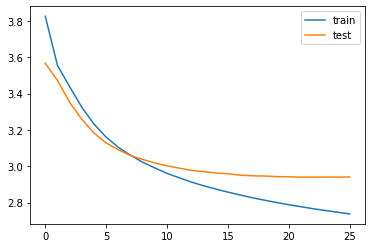

In [140]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 추론 모델 설계하기

In [141]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [142]:
##### 추론 모델 설계 시작 #####
##### 인코더 설계 시작 #####
# 인코더 설계
encoder_model = Model(
    inputs=encoder_inputs, 
    outputs=[encoder_outputs, state_h, state_c]
)

##### 디코더 설계 시작 #####
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 설계
decoder_inputs = Input(shape=(None,))

dec_emb_inf = Embedding(
    tar_vocab, 
    embedding_dim
)(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs_inf, state_h_inf, state_c_inf = LSTM(
    hidden_size, 
    return_sequences=True, 
    return_state=True, 
    dropout=0.4
)(dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

# 어텐션 층(어텐션 함수)
attn_out_inf = AdditiveAttention(
    name='attention_layer'
)([
    decoder_outputs_inf, ## query
    decoder_hidden_state_input  ## key & value
])

decoder_inf_concat = Concatenate(
    axis=-1, 
    name='concat'
)([decoder_outputs_inf, attn_out_inf])

# 디코더의 출력층
decoder_outputs_inf = Dense(
    tar_vocab, 
    activation='softmax'
)(decoder_inf_concat) 
##### 추론 모델 설계 완료 #####

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf] + [state_h_inf, state_c_inf])

In [143]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [144]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if i not in [0, 1, 2]:    ## key error : if (i!=0) and (i!=1) 에서 변경       
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [145]:
for i in range(10, 15):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : nasa mars rover begun climbing metre tall gained metres travelled kilometres landing site base notably car sized rover landed mars sent back lakh images ever since 
실제 요약 : mars begins to top 
예측 요약 :  built built built built built built built built built built built


원문 : indo tibetan border police special water bottles keep water prevent freezing cold regions india china border paramilitary personnel heat food items provided bowl comes bottle tea also made said home ministry official 
실제 요약 : gets special water that can be used to make tea 
예측 요약 :  built built built built built built built built built built built


원문 : denying reports wife ankita approached bigg boss said nobody approached yet bigg boss idea happened know even coming names confirmed always like choose names put added 
실제 요약 : denies being for bigg boss 
예측 요약 :  built built built built built built built built built built built


원문 : delhi chief minister arvind kejriwal tuesday said pm narendra modi led gover

#### 에러 사항
```
원문 : delhi chief minister arvind kejriwal tuesday said pm narendra modi led government fall begun kejriwal comment came assembly election results showed bjp trailing five states according latest trends counting votes assembly elections madhya pradesh close contest bjp congress 
실제 요약 : sostoken of pm modi government fall has kejriwal 
예측 요약 :  cook cook cook cook cook cook cook cook cook cook cook


원문 : model turned actor pandya said get worked referred actress deepika padukone ex boyfriend much right added making acting debut upcoming kangana ranaut starrer manikarnika queen jhansi 
실제 요약 : sostoken do not get up on being called deepika ex 
예측 요약 :  cook cook cook cook cook cook cook cook cook cook cook
```
와 같이 오류가 생성됨
-> 아직 해결 못함.

## 회고
노드대로 할걸... 
끝나고 다시 시도해봐야겟다.